# Importing libraries <a id="1"></a>

In [1]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

# Loading Dataset <a id="2"></a>

In [2]:
# Construct a tf.data.Dataset
data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin', names = ['polarity','id','date','query','user','text'])

# Data Visualization <a id="3"></a>

In [3]:
print("Dataset shape:", data.shape)

Dataset shape: (1600000, 6)


In [4]:
data.head(10)

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [5]:
data['polarity'].unique()

array([0, 4])

In [6]:
# Replacing the value 4 -->1 for ease of understanding.
data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
data.describe()

,polarity,id
count,1600000.0,1.600000e+06
mean,0.5,1.998818e+09
std,0.5,1.935761e+08
min,0.0,1.467810e+09
25%,0.0,1.956916e+09
50%,0.5,2.002102e+09
75%,1.0,2.177059e+09
max,1.0,2.329206e+09


In [8]:
# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity == 1 ]
negatives = data['polarity'][data.polarity == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         1600000
No. of positve tagged sentences is:  800000
No. of negative tagged sentences is: 800000


In [11]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(20)

[('the', 518734),
 ('and', 295675),
 ('you', 237766),
 ('for', 214051),
 ('have', 143295),
 ('that', 128775),
 ("i'm", 127616),
 ('but', 124676),
 ('just', 124454),
 ('with', 113488),
 ('was', 102742),
 ('not', 102160),
 ('this', 88151),
 ('get', 80943),
 ('good', 77367),
 ('are', 75994),
 ('like', 75424),
 ('all', 74076),
 ('out', 68953),
 ('your', 64854)]

# Data Processing <a id="4"></a>

<AxesSubplot:xlabel='polarity', ylabel='count'>

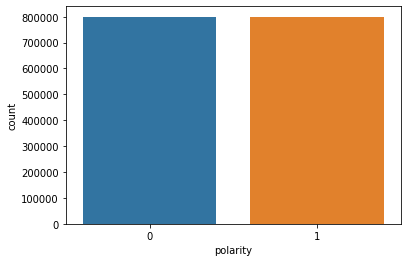

In [12]:
%matplotlib inline
sns.countplot(data['polarity'])

In [13]:
# Removing the unnecessary columns.
data.drop(['date','query','user','word count'], axis=1, inplace=True)

In [14]:
data.drop('id', axis=1, inplace=True)

In [15]:
data.head(10)

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [16]:
#Checking if any null values present
(data.isnull().sum() / len(data))*100

polarity    0.0
text        0.0
dtype: float64

In [17]:
#convrting pandas object to a string type
data['text'] = data['text'].astype('str')

In [18]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'doing', 'below', 'ourselves', 'does', 'there', 'before', 'now', 'himself', 'ma', "you'd", 'mustn', 'shan', 'needn', 'by', 'into', 'those', 'and', 'about', 'been', 'the', 'only', 'myself', 'we', 'herself', 're', 'a', 'yours', "doesn't", 'both', "couldn't", 'wouldn', 'is', 'how', 'from', 'o', "don't", 'your', 's', 'me', 'until', 'was', 'as', 'other', 'don', 'to', 'itself', "shouldn't", 'against', 'd', 'of', 'after', "hasn't", 'if', 'same', 'theirs', 'being', "aren't", "weren't", 'here', "hadn't", 'am', 'in', 'no', 'up', 'such', 'you', 'i', 'whom', 'his', 'when', 'm', 'can', 'hers', "shan't", 'll', 'just', 'who', 'him', 'each', 'has', 'having', 'aren', 'she', 'any', 'over', 'own', 'it', "didn't", 'our', 'y', 'he', 'very', "should've", 'hadn', 'be', 'above', 'won', "wasn't", 'hasn', 'weren', "you're", 'did', 'again', 'not', 'isn', "you've", 'had', "needn't", 'its', 'this', 

In [19]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

> The Preprocessing steps taken are:

* Lower Casing: Each text is converted to lowercase.
* Removing URLs: Links starting with "http" or "https" or "www" are replaced by "".

* Removing Usernames: Replace @Usernames with word "". (eg: "@XYZ" to "")
* Removing Short Words: Words with length less than 2 are removed.
* Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
* Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)


In [20]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [21]:
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [22]:
data.head(10)

,polarity,text,processed_tweets
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww thats bummer shoulda got david...
1,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,kenichan dived many time ball managed save 50 ...
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving im mad cant see
5,0,@Kwesidei not the whole crew,kwesidei whole crew
6,0,Need a hug,eed hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,loltrish hey long time see yes rain bit bit lo...
8,0,@Tatiana_K nope they didn't have it,tatianak nope didnt
9,0,@twittera que me muera ?,twittera que muera


### Word-Cloud for Negative tweets.

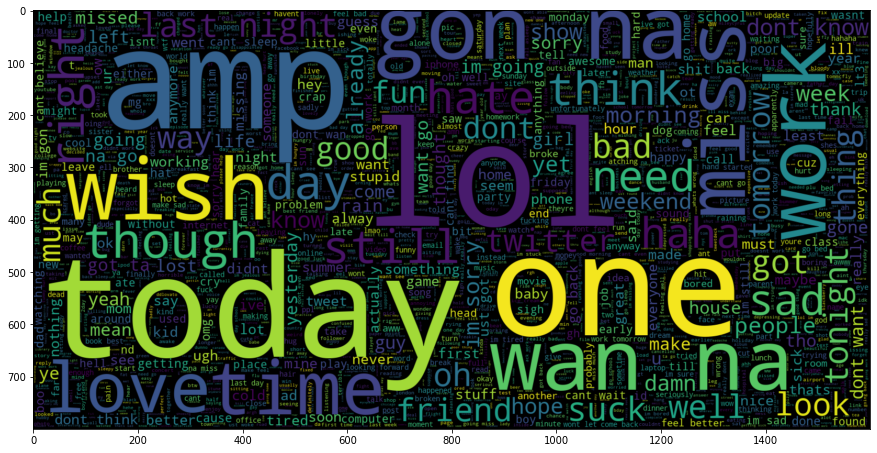

In [23]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 0].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

### Word-Cloud for Positive tweets.

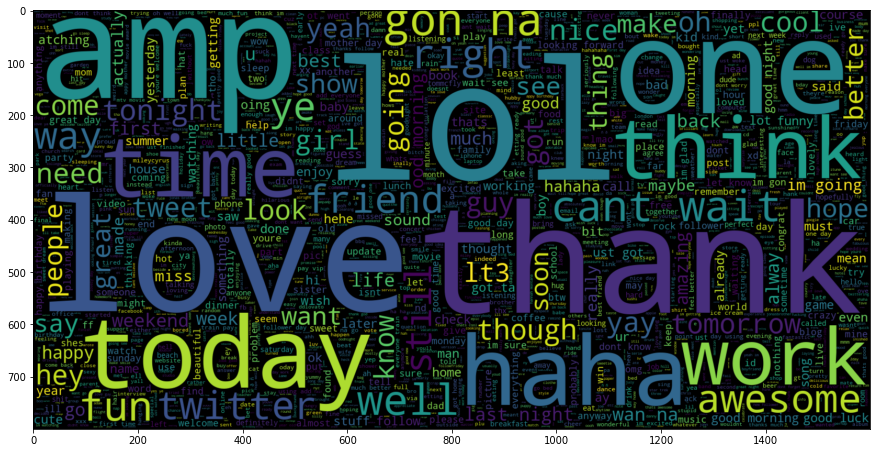

In [24]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 1].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

## Vectorization and Splitting the data <a id="6"></a>


In [25]:
X = data['processed_tweets'].values
y = data['polarity'].values


In [26]:
print(X.shape)
print(y.shape)

(1600000,)
(1600000,)


## Convert text to word frequency vectors
### TF-IDF


In [27]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names()))

Vector fitted.
No. of feature_words:  762358


In [28]:
print(X.shape)
print(y.shape)

(1600000, 762358)
(1600000,)


## Split train and test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [30]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1280000, 762358)
y_train (1280000,)

X_test (320000, 762358)
y_test (320000,)


# Model Building <a id="7"></a>

### Model evaluating function

In [31]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Linear SVM <a id="9"></a>

Accuracy of model on training data : 89.192578125
Accuracy of model on testing data : 77.8465625 

              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159763
           1       0.77      0.79      0.78    160237

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



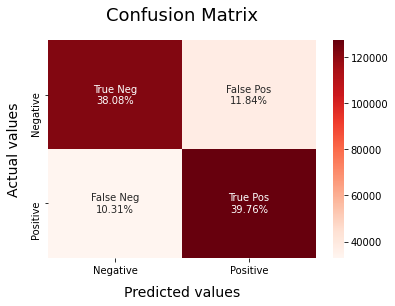

In [33]:
svm = LinearSVC()
svm.fit(X_train, y_train)
model_Evaluate(svm)

### Random Forest <a id="10"></a>

Accuracy of model on training data : 69.92101562500001
Accuracy of model on testing data : 68.534375 

              precision    recall  f1-score   support

           0       0.73      0.59      0.65    159763
           1       0.66      0.78      0.71    160237

    accuracy                           0.69    320000
   macro avg       0.69      0.69      0.68    320000
weighted avg       0.69      0.69      0.68    320000



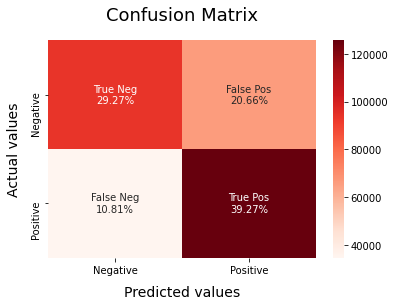

In [34]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)

# RNN <a id="12"></a>

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re

In [37]:
import keras
keras.__version__

'2.4.3'

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.processed_tweets)
sequences = tokenizer.texts_to_sequences(data.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  759 1865    2]
 [   0    0    0 ...   11  187 1283]
 [   0    0    0 ...  368    6 3132]
 ...
 [   0    0    0 ...  123  504 1746]
 [   0    0    0 ...  415 4997   12]
 [   0    0    0 ...    0    0  458]]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data.polarity.values, test_size=0.2, random_state=101)

In [40]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint2])


Epoch 1/10
40000/40000 [==============================] - 671s 17ms/step - loss: 0.4900 - accuracy: 0.7602 - val_loss: 0.4557 - val_accuracy: 0.7825

Epoch 00001: val_accuracy improved from -inf to 0.78254, saving model to rnn_model.hdf5
Epoch 2/10
40000/40000 [==============================] - 658s 16ms/step - loss: 0.4533 - accuracy: 0.7842 - val_loss: 0.4508 - val_accuracy: 0.7856

Epoch 00002: val_accuracy improved from 0.78254 to 0.78559, saving model to rnn_model.hdf5
Epoch 3/10
40000/40000 [==============================] - 663s 17ms/step - loss: 0.4458 - accuracy: 0.7892 - val_loss: 0.4490 - val_accuracy: 0.7867

Epoch 00003: val_accuracy improved from 0.78559 to 0.78669, saving model to rnn_model.hdf5
Epoch 4/10
40000/40000 [==============================] - 651s 16ms/step - loss: 0.4427 - accuracy: 0.7911 - val_loss: 0.4515 - val_accuracy: 0.7873

Epoch 00004: val_accuracy improved from 0.78669 to 0.78729, saving model to rnn_model.hdf5
Epoch 5/10
40000/40000 [===============

In [41]:
sequence = tokenizer.texts_to_sequences(['It really bugged me.'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model2.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')
# print(pred)

Negative


In [42]:
model = keras.models.load_model('rnn_model.hdf5')
sequence = tokenizer.texts_to_sequences(['Parenting is awesome.'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

Positive


In [43]:
sequence = tokenizer.texts_to_sequences(['The train smells bad.'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

Negative
